### **Connect with google drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Check Gpu In Google Colab**
it recommended to use Gpu for accelerate learning.

In [2]:
!nvidia-smi -L


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

''

### **import Library**


In [3]:
# !pip install deepface

In [3]:
import os
import cv2
import pandas as pd
import math
import random as rd
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import Video,Audio
import librosa
import librosa.display
import soundfile as sf
import pickle
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import dlib

%matplotlib inline
 
from deepface import DeepFace
from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace, DeepID
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.commons import functions, realtime, distance as dst


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,LSTM,\
                            TimeDistributed,Flatten,Dense,Bidirectional,ConvLSTM2D,MaxPooling3D,AveragePooling2D,Lambda,\
                            Activation,BatchNormalization

from tensorflow import keras


In [8]:
seed_constant = 27
np.random.seed(seed_constant)
rd.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
DIR='/content/drive/MyDrive/'

### **import data**

In [ ]:
import pickle
dbfile = open('df_', 'rb')     
df = pickle.load(dbfile)

dbfile = open('df_logmel', 'rb')
df_audio = pickle.load(dbfile)

dbfile = open('labels_', 'rb')     
labels = pickle.load(dbfile)

In [ ]:
import glob
folder='/content/drive/MyDrive/ravdess_melspec/'
path_mels=glob.glob(folder+"*.png")

In [ ]:
df=np.ones((1440,224, 224, 3),dtype='uint8')
for i in range(1440):
  img=cv2.imread(path_mels[i])
  img=cv2.resize(img,(224, 224))
  df_audio[i]=img

In [ ]:
import pickle
dbfile = open('data', 'rb')     
df = pickle.load(dbfile)

labels = df['labels']
df=df['features']

In [ ]:
from sklearn.utils import shuffle
df, labels = shuffle(df,df_audio ,labels,random_state=27)
df, labels = shuffle(df,df_audio,labels,random_state=7)
df, labels = shuffle(df,df_audio ,labels,random_state=42)
# |3 shuufle

## **Recognition emotion of sequence of frame**

In [ ]:
import pickle
dbfile = open('df_', 'rb')     
df = pickle.load(dbfile)

dbfile = open('df_logmel', 'rb')
df_audio = pickle.load(dbfile)

dbfile = open('labels_', 'rb')     
labels = pickle.load(dbfile)

In [ ]:
from tensorflow.keras.models import Model
emotion=Emotion.loadModel()
features_emotion=Model(inputs=emotion.input, outputs=emotion.get_layer('dense_1').output)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 85.9MB/s]


In [ ]:
features_emotion.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 7, 7, 64)         0         
 ooling2D)                                                   

In [ ]:
df_=np.ones((1440,20,48, 48))
for i in range(1440):
  for j in range(20):
    img=df[i][j]
    img=img.astype(np.float32)
    # df_[i][j]=cv2.resize(img,(48, 48))/255
    df_[i][j]=img/255
df=df_
df_=[]

In [ ]:
features_emotion.trainable=False


### **STN — Spatial Transformer Network**

In [ ]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 2, 3]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [ ]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

### **lrcn approach (long-term recurrent convolutional networks)**

In [ ]:
emotions_en = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

In [ ]:
def create__LRCN_with_STN() :
  image = tf.keras.layers.Input(shape=(20,48,48,1))
  theta = TimeDistributed(Localization())(image)
  x = TimeDistributed(BilinearInterpolation(height=48, width=48))([image, theta])
  features=TimeDistributed(features_emotion)(x)
  lstm=Bidirectional(LSTM(200, activation='tanh',input_shape=(20, 1024),dropout=.3))(features)
  out=Dense(len(emotions_en), activation = 'softmax')(lstm)

  return tf.keras.models.Model(inputs=image, outputs=out)


In [ ]:
create__LRCN_with_STN().summary()

Building Localization Network with input shape: (None, 48, 48, 1)
Building Bilinear Interpolation Layer with input shape: ((None, 48, 48, 1), (None, 2, 3))
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 48, 48,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 20, 2, 3)    43086       ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (N

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
from sklearn.model_selection import StratifiedKFold

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# indices=[]
# for train_index, test_index in kfold.split(df,labels):
#   indices.append([train_index, test_index])

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = os.path.abspath(DIR)+'/saved_models_lrcn_stn/'
fold_var = 1

for train, test in kfold.split(df, labels):
  # with tpu_strategy.scope():
  model=create__LRCN_with_STN() 
  model.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
  early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
        monitor='val_accuracy', 
        save_best_only=True, mode='max')

  LRCN_model_training_history = model.fit(        x = df[train],
                                                  y = labels[train],
                                                  validation_data=(df[test],labels[test]),
                                                  epochs = 80,
                                                  batch_size = 8,
                                                  shuffle = True,
                                                  callbacks = [checkpoint_cb,early_stopping_callback])

  model.load_weights(save_dir+"model_"+str(fold_var)+".h5")
	
  results = model.evaluate(df[test],labels[test])
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

Building Localization Network with input shape: (None, 48, 48, 1)
Building Bilinear Interpolation Layer with input shape: ((None, 48, 48, 1), (None, 2, 3))
Epoch 1/80
144/144 [==============================] - 41s 142ms/step - loss: 1.4537 - accuracy: 0.4566 - val_loss: 1.1806 - val_accuracy: 0.5556
Epoch 2/80
144/144 [==============================] - 19s 133ms/step - loss: 1.1503 - accuracy: 0.5668 - val_loss: 1.1653 - val_accuracy: 0.5590
Epoch 3/80
144/144 [==============================] - 17s 120ms/step - loss: 1.0095 - accuracy: 0.6137 - val_loss: 1.0452 - val_accuracy: 0.6042
Epoch 4/80
144/144 [==============================] - 17s 119ms/step - loss: 0.8901 - accuracy: 0.6701 - val_loss: 1.0238 - val_accuracy: 0.6215
Epoch 5/80
144/144 [==============================] - 17s 117ms/step - loss: 0.7520 - accuracy: 0.7292 - val_loss: 1.0834 - val_accuracy: 0.6042
Epoch 6/80
144/144 [==============================] - 18s 127ms/step - loss: 0.6530 - accuracy: 0.7656 - val_loss: 1.11

## **Speech emotion regonition**

we use alexnet architecture , but we change parameter for these architecture ,because ,it is large.
or use feature technique with model pre-trained.

In [1]:
def model_alexnet():
  AlexNet = Sequential()

  #1st Convolutional Layer
  AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))

  #2nd Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))

  #3rd Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #4th Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #5th Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))

  #Passing it to a Fully Connected layer
  AlexNet.add(Flatten())
  AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(Dropout(0.4))

  # #2nd Fully Connected Layer
  # AlexNet.add(Dense(4096))
  # AlexNet.add(BatchNormalization())
  # AlexNet.add(Activation('relu'))
  # #Add Dropout
  # AlexNet.add(Dropout(0.4))

  #3rd Fully Connected Layer
  AlexNet.add(Dense(1000))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #Output Layer
  AlexNet.add(Dense(8))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('softmax'))

  return AlexNet 

In [6]:
base_model = tf.keras.applications.EfficientNetV2B1(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False
def model_feature_extraction():
  inputs = keras.Input(shape=(224, 224, 3))
  x = tf.cast(inputs, tf.float32)
  # x = tf.keras.applications.efficientnet.preprocess_input(x)
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  inter = keras.layers.Dense(1024,activation='relu')(x)
  outputs = keras.layers.Dense(8,activation = 'softmax')(inter)
  model = keras.Model(inputs, outputs)
  model.summary()

  return model 

28456008/28456008 [==============================] - 2s 0us/step


In [ ]:
VALIDATION_ACCURACY_SPEECH = []
VALIDATION_LOSS_SPEECH= []

save_dir = os.path.abspath(DIR)+'/saved_model_feature_extraction/'
fold_var = 1

for train, test in kfold.split(df_audio, labels):
  # with tpu_strategy.scope():
  model=model_feature_extraction() 
  model.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
  early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
        monitor='val_accuracy', 
        save_best_only=True, mode='max')

  LRCN_model_training_history = model.fit(        x = df_audio[train],
                                                  y = labels[train],
                                                  validation_data=(df_audio[test],labels[test]),
                                                  epochs = 80,
                                                  batch_size = 8,
                                                  shuffle = True,
                                                  callbacks = [checkpoint_cb,early_stopping_callback])

  model.load_weights(save_dir+"model_"+str(fold_var)+".h5")
	
  results = model.evaluate(df_audio[test],labels[test])
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY_SPEECH.append(results['accuracy'])
  VALIDATION_LOSS_SPEECH.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

## **Model Multi_model with technique late-fusion**

In [ ]:
indice_fold=4

In [4]:
from tensorflow.keras.models import load_model

save_dir = os.path.abspath(DIR)+'/saved_model_feature_extraction/'

model_audio = model_feature_extraction()

model_audio.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


model_audio.load_weights(save_dir+"model_"+str(indice_fold)+".h5")

ValueError: ignored

In [ ]:
save_dir = os.path.abspath(DIR)+'/saved_models_lrcn_stn/'

model_video = create__LRCN_with_STN()

model_video.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


model_video.load_weights(save_dir+"model_"+str(indice_fold)+".h5")

In [ ]:
from sklearn.model_selection import StratifiedKFold

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
indices=[]
for train_index, test_index in kfold.split(df,labels):
  indices.append([train_index, test_index])

In [ ]:
features_video_model=Model(inputs=model_video.input, outputs=model_video.get_layer('bidirectional_2').output)

In [ ]:
features_video=features_video_model.predict(df)

In [ ]:
features_video.shape

(1440, 400)

In [ ]:
features_audio_model=Model(inputs=model_audio.input, outputs=model_audio.get_layer('dropout_11').output)

In [ ]:
features_audio=features_video_model.predict(df_audio)

In [ ]:
features_audio.shape

(1440, 1000)

In [ ]:
data=np.concatenate((features_video,features_audio),axis=1)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 24.6 MB/s 
     |████████████████████████████████| 209 kB 59.0 MB/s 
     |████████████████████████████████| 81 kB 11.3 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 112 kB 75.8 MB/s 
     |████████████████████████████████| 147 kB 59.0 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=745d03b046a24945b4102b5ebe9d4bde70ab157b0eaa76b9346858b3c52e0423
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
indice_train,indice_test=indices[indice_fold]

In [ ]:
X_train, y_train = data[indice_train],labels[indice_train]
X_test, y_test = data[indice_test],labels[indice_test]

In [ ]:
import gc

import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import optuna

In [ ]:
from sklearn import linear_model


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

lda = PCA(n_components=800)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [ ]:
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
    clf = linear_model.LogisticRegression(C=logreg_c)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    score = accuracy_score(y_test, preds)
    gc.collect()
    return score

In [ ]:
study = optuna.create_study(study_name="tps-feb-2022", direction="maximize")
study.optimize(objective, n_trials=30)

[I 2022-07-30 15:58:20,061] A new study created in memory with name: tps-feb-2022
[I 2022-07-30 15:58:20,461] Trial 0 finished with value: 0.4513888888888889 and parameters: {'classifier': 'LogReg', 'logreg_c': 1.9185191780082076e-09}. Best is trial 0 with value: 0.4513888888888889.
[I 2022-07-30 15:58:20,887] Trial 1 finished with value: 0.8541666666666666 and parameters: {'classifier': 'LogReg', 'logreg_c': 3474462.9059616425}. Best is trial 1 with value: 0.8541666666666666.
[I 2022-07-30 15:58:21,282] Trial 2 finished with value: 0.8541666666666666 and parameters: {'classifier': 'LogReg', 'logreg_c': 3951278.0562358587}. Best is trial 1 with value: 0.8541666666666666.
[I 2022-07-30 15:58:21,685] Trial 3 finished with value: 0.8541666666666666 and parameters: {'classifier': 'LogReg', 'logreg_c': 5937721422.100135}. Best is trial 1 with value: 0.8541666666666666.
[I 2022-07-30 15:58:22,098] Trial 4 finished with value: 0.4513888888888889 and parameters: {'classifier': 'LogReg', 'logre

In [ ]:
study = optuna.create_study(study_name="tps-feb-2022", direction="maximize")
study.optimize(objective, n_trials=30)

[I 2022-07-30 15:58:53,462] A new study created in memory with name: tps-feb-2022
[I 2022-07-30 15:58:54,899] Trial 0 finished with value: 0.8298611111111112 and parameters: {'classifier': 'SVC', 'C': 1.7223160821850578, 'gamma': 0.01, 'kernel': 'linear'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:58:55,468] Trial 1 finished with value: 0.8298611111111112 and parameters: {'classifier': 'SVC', 'C': 0.32380268998790485, 'gamma': 0.01, 'kernel': 'linear'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:58:55,925] Trial 2 finished with value: 0.8298611111111112 and parameters: {'classifier': 'SVC', 'C': 0.09508516053085085, 'gamma': 0.01, 'kernel': 'linear'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:58:56,537] Trial 3 finished with value: 0.7743055555555556 and parameters: {'classifier': 'SVC', 'C': 0.21278468718783977, 'gamma': 0.01, 'kernel': 'poly'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:58:57,03

In [ ]:
trial = study.best_trial
print("  Best accuracy: ", study.best_value)
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Best accuracy:  1.0
  Value: 1.0
  Params: 
    classifier: SVC
    C: 2.76516893928621
    gamma: 0.01
    kernel: rbf


In [ ]:
def multi_modal_NN():
  model=Sequential()
  model.add(Input(shape=(800)))
  
  model.add(Dense(2096))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(8))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))
  return model

In [ ]:
model=multi_modal_NN()

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_final.h5", monitor='val_accuracy',save_best_only=True, mode='max')
# Start training the model.
LRCN_model_training_history = model.fit(          x = X_train,
                                                  y = y_train,
                                                  validation_data=(X_test, y_test),
                                                  epochs = 80,
                                                  batch_size = 4,
                                                  shuffle = True,
                                                  callbacks = [checkpoint_cb,early_stopping_callback])

Epoch 1/80
288/288 [==============================] - 16s 53ms/step - loss: 1.0873 - accuracy: 0.7804 - val_loss: 0.7374 - val_accuracy: 0.8125
Epoch 2/80
288/288 [==============================] - 15s 52ms/step - loss: 0.9407 - accuracy: 0.8333 - val_loss: 0.7485 - val_accuracy: 0.8125
Epoch 3/80
288/288 [==============================] - 14s 47ms/step - loss: 0.8641 - accuracy: 0.8646 - val_loss: 0.7058 - val_accuracy: 0.8056
Epoch 4/80
288/288 [==============================] - 15s 51ms/step - loss: 0.7806 - accuracy: 0.8906 - val_loss: 0.6286 - val_accuracy: 0.8472
Epoch 5/80
288/288 [==============================] - 15s 53ms/step - loss: 0.7767 - accuracy: 0.8767 - val_loss: 0.6103 - val_accuracy: 0.8229
Epoch 6/80
288/288 [==============================] - 14s 47ms/step - loss: 0.6927 - accuracy: 0.8941 - val_loss: 0.6066 - val_accuracy: 0.8229
Epoch 7/80
288/288 [==============================] - 13s 46ms/step - loss: 0.7064 - accuracy: 0.8689 - val_loss: 0.5876 - val_accuracy:

In [ ]:
clf = SVC(**trial.params)

In [ ]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [ ]:
score = accuracy_score(y_test, preds)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=27, n_components=2)
X_tsne = tsne.fit_transform(data)

In [ ]:
df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((X_tsne, 
                                            labels)))
# cast targets column to int
df.head()

,CP1,CP2,target
0,-15.891058,4.830784,5.0
1,-18.535702,-36.050522,1.0
2,-17.263617,58.799301,4.0
3,-9.052793,62.044937,4.0
4,38.535046,-38.086552,7.0


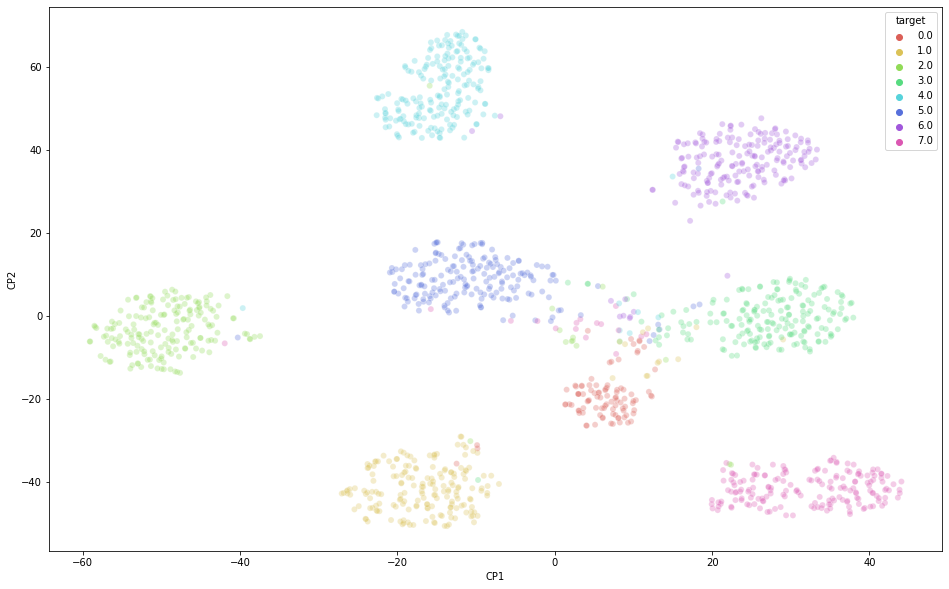

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="CP1", y="CP2",
    hue="target",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3)

In [ ]:
from sklearn.decomposition import PCA

lda = PCA(n_components=800)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [ ]:
def objective(trial):
    classifier = trial.suggest_categorical('classifier', ["SVC"]) # "SVC", "XGBoostClassifier"
    if classifier == "LogReg":
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        clf = linear_model.LogisticRegression(C=logreg_c)
    if classifier == "SVC":
        svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
        svc_gamma = trial.suggest_float("gamma", 1e-2, 1e-2, log=True)
        svc_kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        clf = SVC(C=svc_c, kernel=svc_kernel, gamma=svc_gamma)
    elif classifier == "RandomForestClassifier":
        n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
        max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier == "XGBoostClassifier":
        pass
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    score = accuracy_score(y_test, preds)
    gc.collect()
    return score

In [ ]:
study = optuna.create_study(study_name="tps-feb-2022", direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-07-30 15:57:02,251] A new study created in memory with name: tps-feb-2022
[I 2022-07-30 15:57:02,489] Trial 0 finished with value: 0.8298611111111112 and parameters: {'classifier': 'SVC', 'C': 0.05504162291035254, 'gamma': 0.01, 'kernel': 'linear'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:57:02,787] Trial 1 finished with value: 0.7743055555555556 and parameters: {'classifier': 'SVC', 'C': 55.271551935415076, 'gamma': 0.01, 'kernel': 'poly'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:57:03,008] Trial 2 finished with value: 0.8298611111111112 and parameters: {'classifier': 'SVC', 'C': 91.74725824647703, 'gamma': 0.01, 'kernel': 'linear'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:57:03,301] Trial 3 finished with value: 0.7743055555555556 and parameters: {'classifier': 'SVC', 'C': 0.5458049312423807, 'gamma': 0.01, 'kernel': 'poly'}. Best is trial 0 with value: 0.8298611111111112.
[I 2022-07-30 15:57:03,511] Tr

In [ ]:
study = optuna.create_study(study_name="tps-feb-2022", direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-07-30 15:32:09,035] A new study created in memory with name: tps-feb-2022
[I 2022-07-30 15:32:09,707] Trial 0 finished with value: 0.8194444444444444 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.0007624482666916859}. Best is trial 0 with value: 0.8194444444444444.
[I 2022-07-30 15:32:10,530] Trial 1 finished with value: 0.4513888888888889 and parameters: {'classifier': 'LogReg', 'logreg_c': 1.409251970599193e-10}. Best is trial 0 with value: 0.8194444444444444.
[I 2022-07-30 15:32:11,895] Trial 2 finished with value: 0.8194444444444444 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.00010631835935113347}. Best is trial 0 with value: 0.8194444444444444.
[I 2022-07-30 15:32:12,885] Trial 3 finished with value: 0.8506944444444444 and parameters: {'classifier': 'LogReg', 'logreg_c': 853110670.5439802}. Best is trial 3 with value: 0.8506944444444444.
[I 2022-07-30 15:32:13,710] Trial 4 finished with value: 0.4513888888888889 and parameters: {'classifier': 'LogReg', 

In [ ]:
import dlib ,time
detector = dlib.get_frontal_face_detector()

import dlib
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) 
        success, frame = video_reader.read() 
        if not success:
            break
        faces = detector(frame, 0) 
        crop_img = frame[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()]
        resized_frame = cv2.resize(crop_img, (224, 224))
        resized_frame=cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        resized_frame = cv2.resize(resized_frame, (48, 48))
        frames_list.append(resized_frame/255)
        video_reader.release()
 
    return frames_list

i am just check my model with my video, but it not general , 1440 video in very small data.

In [ ]:
t=frames_extraction('/content/drive/MyDrive/test1.mp4')


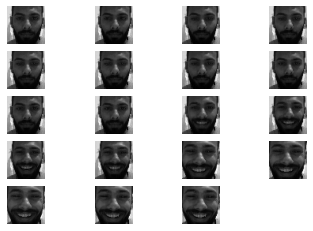

In [ ]:
for i in range(1,20):
    plt.subplot(5, 4, i)
    plt.imshow(t[i],cmap='gray')
    plt.axis('off')

In [ ]:
np.argmax(model.predict(np.array([t])))

2

# **I apologize for not interpreting more, it's because the process takes a long time, but the necessary is mention the most important points, so execute and add visualization of the predictions, matrix of confusion ,check overfitting ...**